In [1]:
import numpy as np

# Setting relative imports in jupyter notebook
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from src import utils
from skimage.segmentation import chan_vese

#%matplotlib tk
import matplotlib.pyplot as plt

### Preparing

First, building the dataframe respective to the dataset content is necessary. This dataframe is composed of general information about the subjects and, in a second moment, the path to the .nii files is added, which are the T1 MRI acquisitions and segmentation masks made by human experts.
The `build_datafram` function has a flag to filter subjects without any segmentation mask. We leave this flag with the default values, i.e., the result dataset only contains subjects with at least one segmentation mask.

In [2]:
# Loading the dataset from the Episurg folder, using the info form subjects.c
df_episurg = utils.build_dataframe('../Episurg', 'subjects.csv')

### Reading an image

The MRI images can be read with the `utils.get_image` function. This function has as parameters the dataset dataframe (`df_episurg`), the identification code for the subject (ex: sub-0002 can be accessed by passing `0002`), the number of the slice desired, and the perspective of the MRI acquisition (a for axial, c for coronal and s for sagittal)

We use the function `utils.show_nii` to present the MRI image.

In [3]:
id_sub = '0035'
slice_n = 119
perspective = 'a'

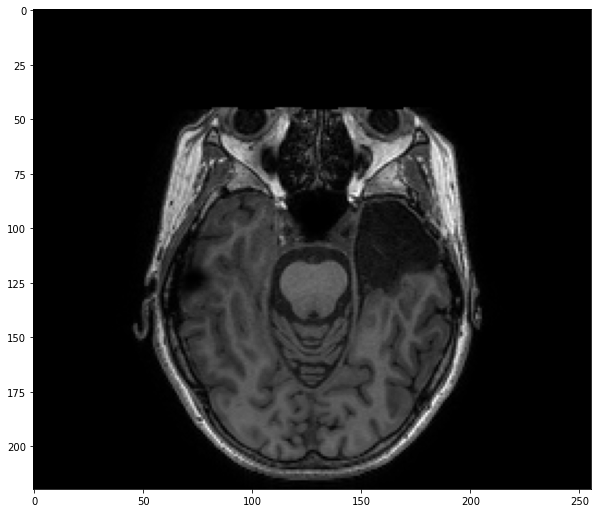

In [4]:
# Loading the MRI image for subject sub-0035, slice 119 from axial perspective
mri_img = utils.get_image(df_episurg, id_sub, slice_n, perspective)
mri_img = np.flip(mri_img)
plt.figure(figsize=(10,10))
utils.show_nii(mri_img)

## Segmentation preprocessing

### Performing the segmentation

To perform the assisted segmentation, the expert must select the region of interest. We simulated that operation by manually setting a pixel (x, y) to select the connected component of segmentation. In this example, the selected pixel was the x = 100  and y = 166.

Choosing $\mu$, $\lambda_{1}$ and $\lambda_{2}$ to perform the method.

Is wanted to see the original image, segmentation and image with mask.

In [14]:
x = 100
y = 160
mu = 0.1
lambda1 = 1
lambda2 = 1.3

In [11]:
def dilation(f, w):
    m, n = w.shape

    mf, nf = f.shape

    a = int((m - 1) / 2)
    b = int((n - 1) / 2)

    r = np.copy(f)

    for xf in range(a, mf - a):
        for yf in range(b, nf - b):
            sub_f = f[xf - a: xf + a + 1, yf - b: yf + b + 1]
            r[xf, yf] = sub_f.max()

    return r.astype(np.uint8)

In [17]:
mask = np.zeros(mri_img.shape)

mri_img = utils.normalize_img(mri_img).astype(np.uint8)

cv = chan_vese(mri_img, mu, lambda1, lambda2, tol=1e-3,
               max_num_iter=150, dt=0.5, init_level_set="checkerboard",
               extended_output=True)

mask[np.where(cv[0] == False)] = 1
mask[np.where(cv[0] == True)] = 0

mask = mask.astype(np.uint8)

Xi = np.zeros(mri_img.shape)
w = np.matrix('0 1 0; 1 1 1; 0 1 0').astype(np.uint8)
Xi[x, y] = 1

flag = True
while flag:
    X_i = dilation(Xi, w)
    X_i = np.bitwise_and(X_i == 1, mask == 1).astype(np.uint8)
    if np.sum(X_i - Xi) == 0:
        flag = False
    Xi = X_i

mri_marked = np.copy(mri_img)
mri_marked[np.where(Xi == 1)] = 255

(-0.5, 255.5, 219.5, -0.5)

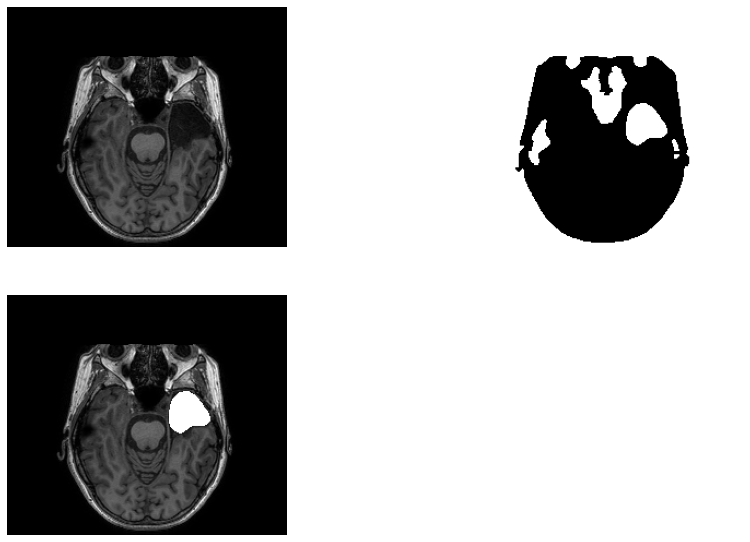

In [18]:
plt.figure(figsize=(15,15))
plt.subplot(321); plt.imshow(mri_img, cmap="gray"); plt.axis('off')
plt.subplot(322); plt.imshow(mask, cmap="gray"); plt.axis('off')
plt.subplot(323); plt.imshow(mri_marked,cmap="gray"); plt.axis('off')
# plt.subplot(324); plt.imshow(img_with_mask, cmap='gray'); plt.axis('off')

1º Image: Original image
2º Image: Segmentation after iterations
3º Image: Original image with mask

### Conclusion

Após o processamento da imagem, observa-se uma segmentação muito próxima da esperada.
O caso analizado visa mostrar como é a segmentação do método e a área semgentada na imagem original. Pode ser feito preprocessamentos anteriores a segmentação para a obtenção de melhores resultados, mas a ideia é mostrar como o método funciona nas imagens originais, com objetivo de entender o método de forma geral.